In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder

### Загрузка данных

In [89]:
data1 = pd.read_csv('data0.csv')
data2 = pd.read_csv('data1.csv')

df = pd.concat([data1, data2], ignore_index=True)
df.head()

,headings,usabilities,used_for_learning,used_for_research,used_for_application,used_for_llm_fine_tuning,well_documented,well_maintained,clean_data,original,high_quality_notebooks,views,downloads,engagements,comments,weight,medal
0,Tortilla prices in Mexico,10.00,4,3,0,0,0,0,2,0,0,9936,1922,0.19344,0,15697.92,NaN
1,Spotify 1.2M+ Songs,8.24,8,0,1,0,1,0,3,0,0,54100,7455,0.13777,2,354037.76,NaN
2,Causes of Death in Indonesia,10.00,8,3,0,0,3,0,0,0,0,52000,10400,0.19994,0,410.80,NaN
3,Indicators of Anxiety or Depression,10.00,0,1,0,0,0,0,0,0,0,6891,1058,0.15353,0,2652.16,NaN
4,diamonds,10.00,0,0,0,0,0,0,0,0,0,2006,331,0.16500,0,3266.56,NaN


### Обработка отсутствующих и категориальных признаков

In [90]:
df['medal'] = df['medal'].fillna('0').astype(str)

In [91]:
label_encoder = LabelEncoder()
df['medal_encoded'] = label_encoder.fit_transform(df['medal'])

In [92]:
df.head()

,headings,usabilities,used_for_learning,used_for_research,used_for_application,used_for_llm_fine_tuning,well_documented,well_maintained,clean_data,original,high_quality_notebooks,views,downloads,engagements,comments,weight,medal,medal_encoded
0,Tortilla prices in Mexico,10.00,4,3,0,0,0,0,2,0,0,9936,1922,0.19344,0,15697.92,0,0
1,Spotify 1.2M+ Songs,8.24,8,0,1,0,1,0,3,0,0,54100,7455,0.13777,2,354037.76,0,0
2,Causes of Death in Indonesia,10.00,8,3,0,0,3,0,0,0,0,52000,10400,0.19994,0,410.80,0,0
3,Indicators of Anxiety or Depression,10.00,0,1,0,0,0,0,0,0,0,6891,1058,0.15353,0,2652.16,0,0
4,diamonds,10.00,0,0,0,0,0,0,0,0,0,2006,331,0.16500,0,3266.56,0,0


### Нормализация данных

In [93]:
df['normalized_usabilities'] = df['usabilities'].apply(np.log1p)

In [94]:
df['normalized_views'] = df['views'].apply(np.log1p) 

In [95]:
df['normalized_downloads'] = df['downloads'].apply(np.log1p)

In [96]:
df['normalized_comments'] = df['comments'].apply(np.log1p)

In [97]:
df['normalized_weight'] = df['weight'].apply(np.log1p)

In [98]:
normalized_columns = ['normalized_usabilities', 'normalized_views', 'normalized_downloads', 'normalized_comments', 'normalized_weight']
columns = ['usabilities', 'views', 'downloads', 'comments', 'weight']

### Гистограммы данных до и после нормализации

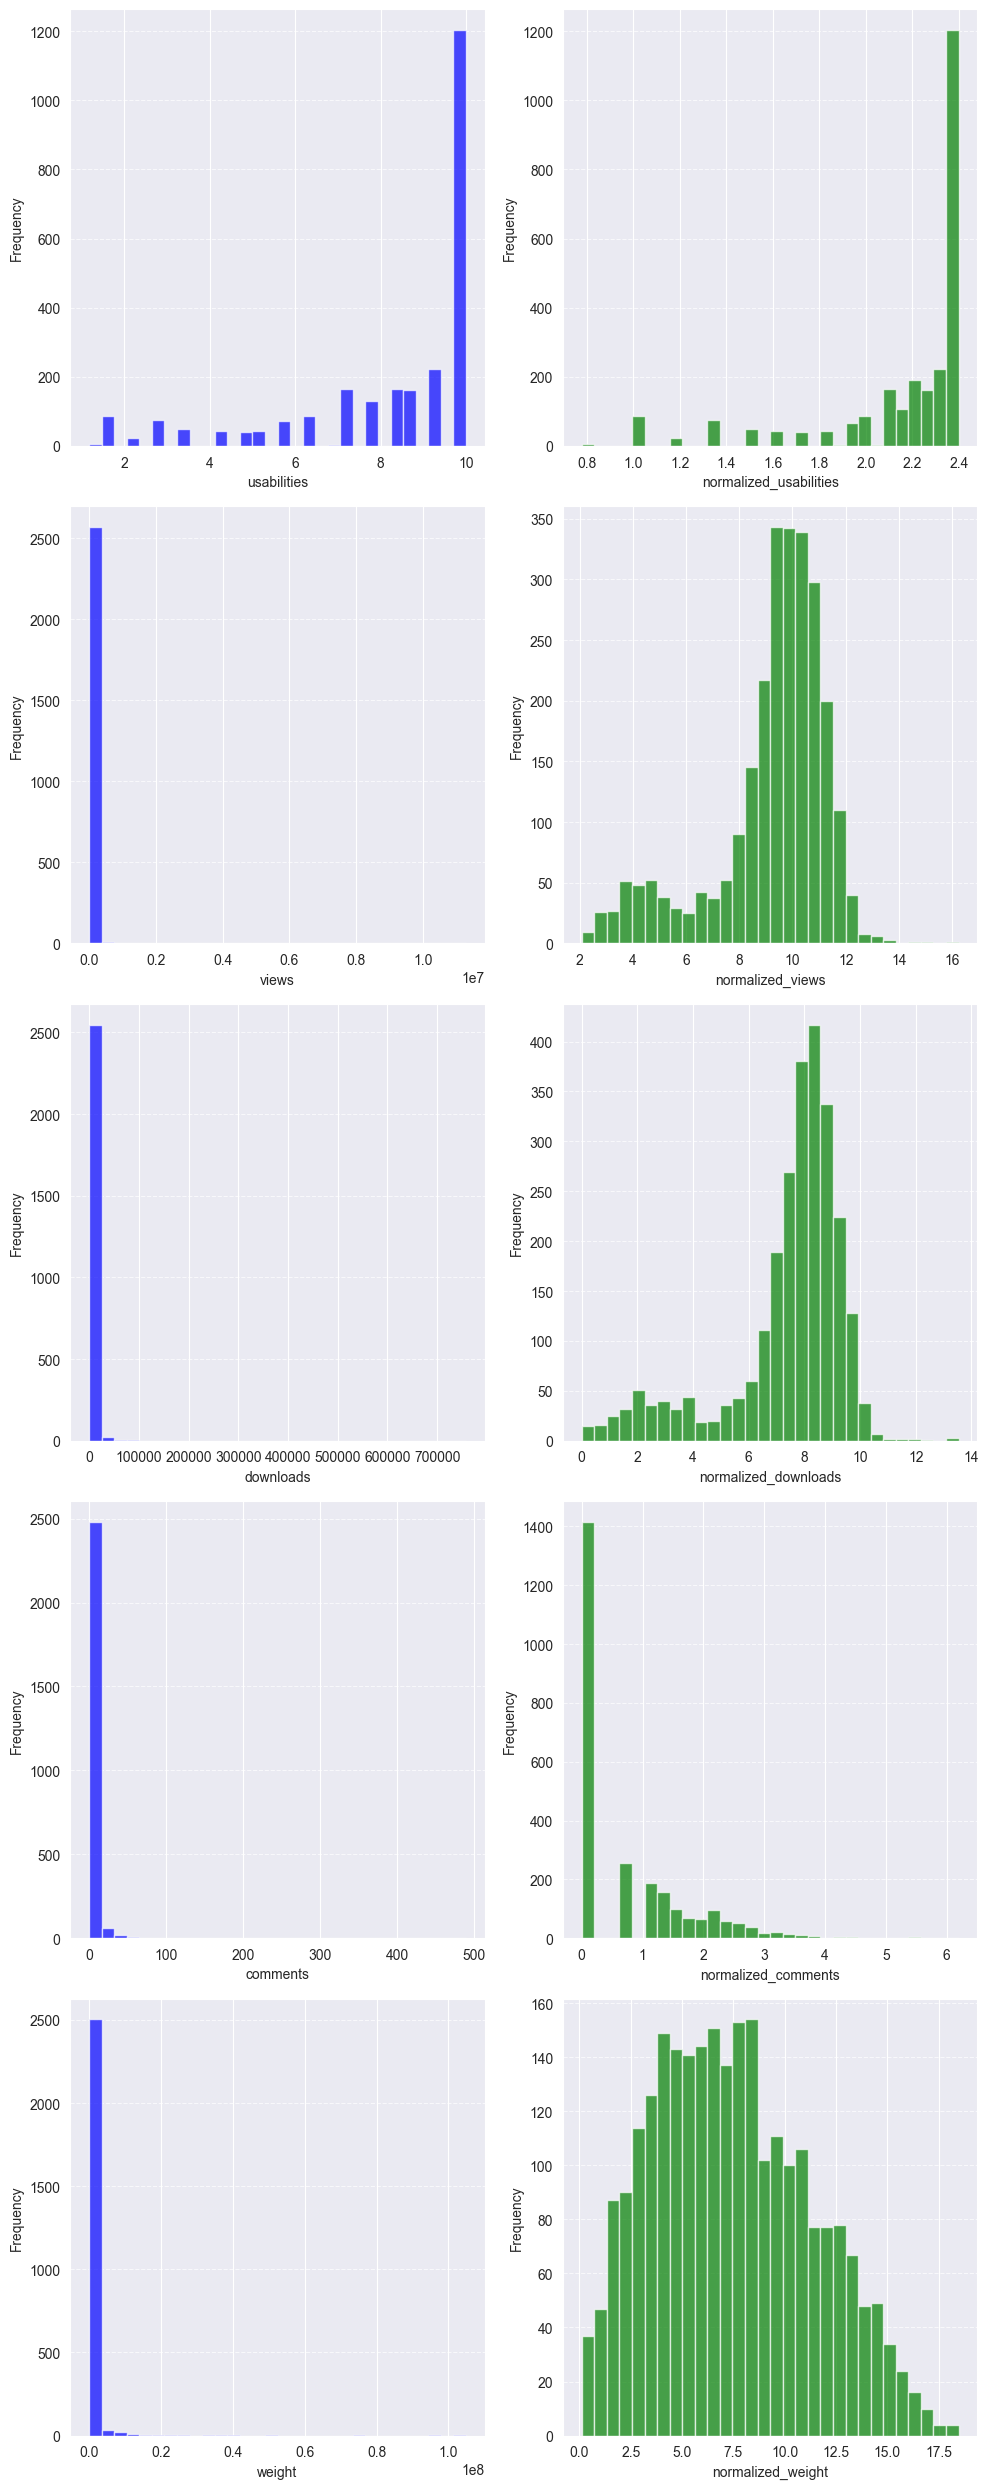

In [99]:
fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for i, (col, norm_col) in enumerate(zip(columns, normalized_columns)):
    for j, data in enumerate([col, norm_col]):
        axes[i, j].hist(df[data], bins=30, alpha=0.7, color=['blue', 'green'][j])
        axes[i, j].set_xlabel(data)
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Запускаем Kmeans и запоминаем силует для разного числа кластеров

In [100]:
normalized_data = df[['normalized_views', 'normalized_downloads', 'normalized_weight']]

In [101]:
silhouette = []

In [102]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=52)
    kmeans.fit(normalized_data)
    silhouette.append(silhouette_score(normalized_data, kmeans.labels_))

### Строим графики чтобы выбрать оптимальное количество кластеров

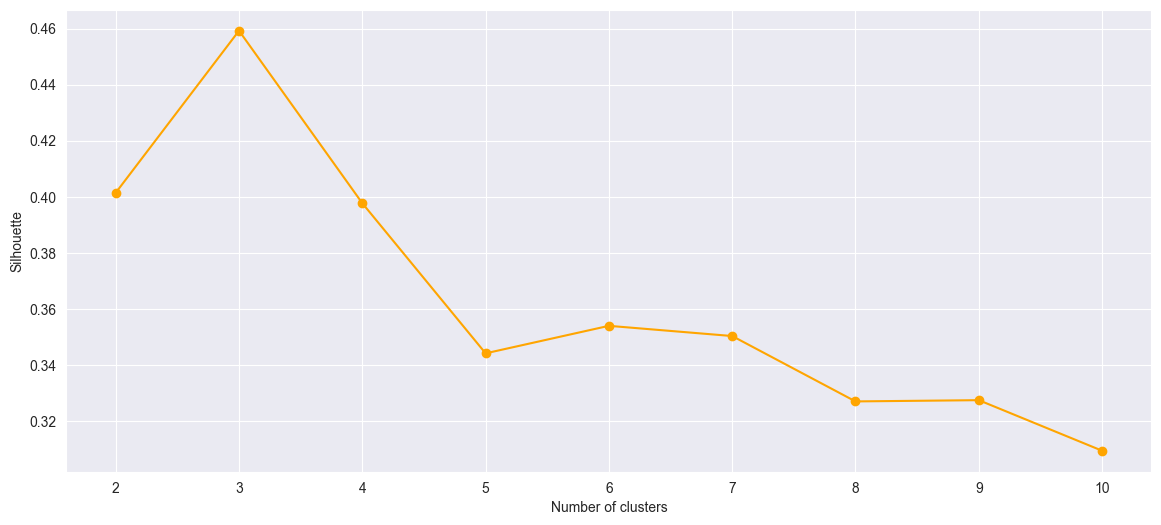

In [103]:
plt.figure(figsize=(14, 6))

plt.plot(range(2, 11), silhouette, marker='o', color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')

plt.show()

In [104]:
optimal_n_clusters = 3

### Запусакаем модельку с 3-мя кластерами

In [105]:
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=52)
clusters = kmeans.fit_predict(normalized_data)

In [106]:
df['Cluster'] = clusters

### Визуализируем

In [107]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(normalized_data)

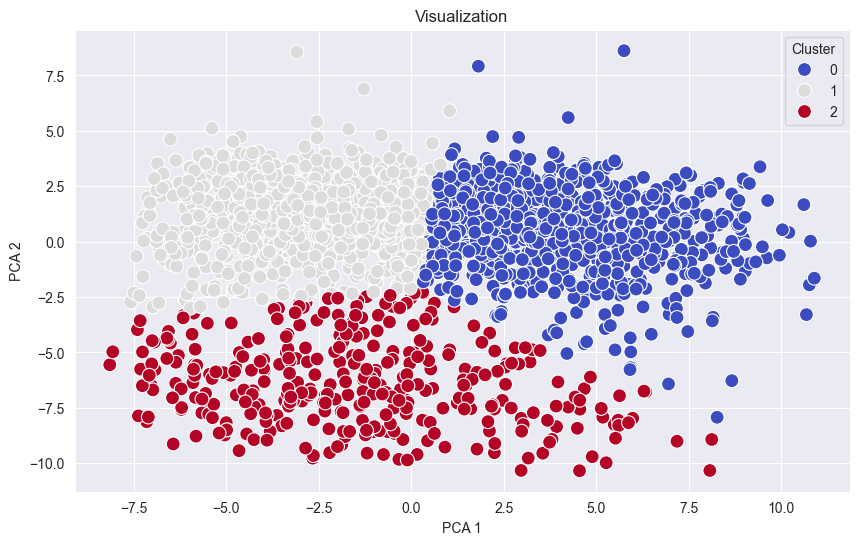

In [108]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_2d[:, 0], y=data_2d[:, 1], 
    hue=df['Cluster'], palette='coolwarm', s=100
)
plt.title('Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

#### Перебор гиперпараметров

In [109]:
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_iter': [30, 40, 50, 70, 100, 150],
}

In [110]:
best_params = None
best_score = -52

In [111]:
for params in ParameterGrid(param_grid):
    kmeans = KMeans(**params, random_state=52)
    clusters = kmeans.fit_predict(normalized_data)
    score = silhouette_score(normalized_data, clusters)
    
    if score > best_score:
        best_score = score
        best_params = params

In [112]:
print("Best parameters:", best_params)
print("Dest Silhouette:", best_score)

Best parameters: {'max_iter': 30, 'n_clusters': 3}
Dest Silhouette: 0.45921581670059547


### Моя реализация

In [113]:
class MyKMeans:
    def __init__(self):
        self.n_clusters = 3
        self.max_iter = 30

    def fit(self, X):
        centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, None] - centers, axis=2)
            labels = np.argmin(distances, axis=1)

            new_centers = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])
            centers = new_centers

        self.centers_ = centers
        self.labels_ = labels   

    def predict(self, X):
        distances = np.linalg.norm(X[:, None] - self.centers_, axis=2)
        return np.argmin(distances, axis=1)

In [114]:
normalized_data = normalized_data.to_numpy()

In [115]:
my_kmeans = MyKMeans()
my_kmeans.fit(normalized_data)

In [116]:
my_labels = my_kmeans.labels_

In [117]:
silhouette_my = silhouette_score(normalized_data, my_labels)

In [118]:
print("Silhouette:", silhouette_my)

Silhouette: 0.45931992164095525


### Сравнение

In [119]:
print("MyKMeans Silhouette:", silhouette_my)
print("Sklearn Silhouette:", best_score)

MyKMeans Silhouette: 0.45931992164095525
Sklearn Silhouette: 0.45921581670059547
